In [1]:
import pandas as pd 
import cv2, numpy as np
import random
from scipy.stats import norm
from scipy.misc import imread, imsave
import re
import idx2numpy as idx
from copy import copy
import os
from datetime import datetime 
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# keras
np.random.seed(13)
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Dropout, Activation, Lambda, Layer # keras.layers.core 
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# logging
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
from copy import copy

In [3]:
rootpath = "../EgyptianHieroglyphDataset/MyTrainTest"
original_dim = (75, 50) # without convolutional layers, use 75 * 50
batch_size = 32 * 4 # this has to be the same as or multiplication of the param value in the analysis code

In [4]:
datagen = ImageDataGenerator(
        rotation_range=10 # TODO too aggressive; Andrew suggests 10 or less
        , width_shift_range=0.05
        # , height_shift_range=0.05
        # , rescale=1./255 # rescale will happen when I import png at analysis
        , shear_range=0.1 # TODO too aggressive; Andrew suggests go way down
        , zoom_range=[1-0.05, 1+0.5]
        , horizontal_flip=False 
            # Egyptian heiroglyphs can actually be flipped depending on whether it's written from left to right
            # or right to left, but it looks like all my training/testing data are facing the same way, so I'll 
            # keep it simple
        , vertical_flip=False
        , fill_mode='nearest' # nearest is default
        , data_format='channels_first'
        )

# train

### first check my data distribution

In [5]:
tr_rootpath = os.path.join(rootpath, "train")
symbol_df = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
symbol_df = pd.DataFrame(sorted(symbol_df))
symbol_df.reset_index(inplace = True)
symbol_df.columns = ["symbol_num", "symbol"]
symbol_df.tail(1)

,symbol_num,symbol
170,170,Z7


In [6]:
tr_rootpath = os.path.join(rootpath, "train")
subdirs = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
tr_fnames = pd.DataFrame(columns = ["fname"])
for subdirpath in subdirs:
    subdir = os.path.join(tr_rootpath, subdirpath)
    files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
    for fpath in files:        
        pngfile = os.path.join(subdir, fpath)
        tr_fnames = pd.concat([tr_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
tr_fnames.reset_index(drop = True, inplace = True)

In [7]:
tr_fnames.tail(1)['fname'].tolist()[0]

'../EgyptianHieroglyphDataset/MyTrainTest/train/G25/gen4_410090_G25.png'

In [8]:
tr_fnames['label'] = tr_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [9]:
tr_fnames.tail(1)

,fname,label
43985,../EgyptianHieroglyphDataset/MyTrainTest/train...,G25


In [93]:
tr_counts = pd.DataFrame(tr_fnames["label"].value_counts())
tr_counts.reset_index(inplace = True)
tr_counts.columns = ["label", "ct"]
tr_counts.sort_values(by = "ct", inplace = True, ascending = False)
tr_counts.reset_index(drop = True, inplace = True)
tr_counts.head(2)

,label,ct
0,N35,403
1,M17,319


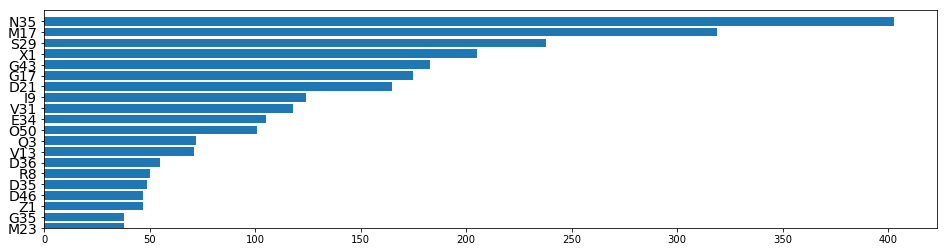

In [94]:
plt.figure(figsize = (16, 4))
n_rows = tr_counts.shape[0]
n_to_display = 20
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, tr_counts["ct"])
plt.yticks(xaxis, tr_counts["label"], fontsize = 14)
plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

### merge info into one table

In [95]:
cap = 256

In [96]:
tr_counts['new_img_ct'] = cap - tr_counts["ct"]
no_need_to_add_img = tr_counts['new_img_ct'] < 0
tr_counts.loc[no_need_to_add_img, 'new_img_ct'] = 0

In [97]:
tr_counts.tail(2)

,label,ct,new_img_ct
169,M26,1,255
170,D53,1,255


In [98]:
print(tr_fnames.shape)
tr_fnames = tr_fnames.merge(tr_counts, on = "label")
print(tr_fnames.shape)

(3586, 2)
(3586, 4)


In [99]:
tr_fnames["rand"] = np.random.random(tr_fnames.shape[0])
tr_fnames = tr_fnames.sort_values(["label", "rand"])
tr_fnames.reset_index(drop = True, inplace = True)
tr_fnames.reset_index(inplace = True)

In [100]:
tr_fnames.tail(2)

,index,fname,label,ct,new_img_ct,rand
3584,3584,../EgyptianHieroglyphDataset/MyTrainTest/train...,Z7,4,252,0.689954
3585,3585,../EgyptianHieroglyphDataset/MyTrainTest/train...,Z7,4,252,0.743827


In [101]:
cond = tr_fnames['new_img_ct'] != 0
cat_and_ct_df = tr_fnames.loc[cond, ['label', 'new_img_ct']].drop_duplicates()
cat_and_ct_df.reset_index(drop = True, inplace = True)
cat_and_ct = {}
for row in range(cat_and_ct_df.shape[0]):
    label = cat_and_ct_df.loc[row, 'label']
    new_img_ct = cat_and_ct_df.loc[row, 'new_img_ct']
    cat_and_ct[label] = new_img_ct

### generate images

In [118]:
start = datetime.now()
shape_dim = (1, 1) + (original_dim)
for item in cat_and_ct.items():
    print(item)
    label = item[0]
    pngfile_li = list(tr_fnames.loc[tr_fnames['label'] == label, 'fname'])
    # print(pngfile_li)
    df_len = len(pngfile_li)
    counter = 0
    row = 0
    i = 0
    while counter < item[1]:
        pngfile = pngfile_li[row] 
        # print(pngfile, "new image", counter, "orig image", row)
        newimg_dir = os.path.join(rootpath, "train", label)
        arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
        arrayfile = np.reshape(arrayfile, shape_dim) # note: no rescaling here!
        genflow = datagen.flow(x = arrayfile, y = None, batch_size=1, save_to_dir=None)
        for new_arrayfile in genflow:
            new_arrayfile = np.reshape(new_arrayfile, original_dim)
            fname = "gen" + str(i) + "_" + pngfile.split("/")[-1]
            fpath = os.path.join(newimg_dir, fname)
            # print(fpath)
            imsave(fpath, new_arrayfile)
            break
        row += 1
        if row >= df_len:
            row = 0
            i += 1
        counter += 1
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

('A55', 255)
('Aa15', 253)
('Aa26', 251)
('Aa27', 254)
('Aa28', 255)
('D1', 252)
('D10', 253)
('D156', 253)
('D19', 254)
('D2', 238)
('D21', 91)
('D28', 240)
('D34', 255)
('D35', 207)
('D36', 201)
('D39', 254)
('D4', 221)
('D46', 209)
('D52', 252)
('D53', 255)
('D54', 244)
('D56', 253)
('D58', 222)
('D60', 250)
('D62', 255)
('E1', 253)
('E17', 255)
('E23', 249)
('E34', 151)
('E9', 249)
('F12', 255)
('F13', 248)
('F16', 251)
('F18', 250)
('F21', 255)
('F22', 255)
('F23', 255)
('F26', 252)
('F29', 255)
('F30', 255)
('F31', 251)
('F32', 255)
('F34', 247)
('F35', 254)
('F4', 252)
('F40', 254)
('F9', 253)
('G1', 231)
('G10', 255)
('G14', 254)
('G17', 81)
('G21', 254)
('G25', 229)
('G26', 254)
('G29', 253)
('G35', 218)
('G36', 247)
('G37', 253)
('G39', 237)
('G4', 248)
('G40', 249)
('G43', 73)
('G5', 228)
('G50', 255)
('G7', 250)
('H6', 249)
('I10', 220)
('I5', 255)
('I9', 132)
('L1', 254)
('M1', 253)
('M12', 253)
('M16', 254)
('M18', 245)
('M195', 253)
('M20', 254)
('M23', 218)
('M26', 255)

Z7 0 63 ../EgyptianHieroglyphDataset/MyTrainTest/train/Z7/gen62_390316_Z7.png


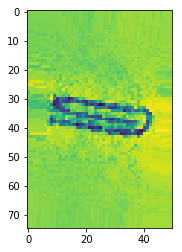

In [119]:
# spot check
print(label, row, i, fpath)
plt.figure()
plt.imshow(np.reshape(new_arrayfile, original_dim))
plt.show()

### double check resulting distribution

In [120]:
tr_rootpath = os.path.join(rootpath, "train")
symbol_df = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
symbol_df = pd.DataFrame(sorted(symbol_df))
symbol_df.reset_index(inplace = True)
symbol_df.columns = ["symbol_num", "symbol"]
symbol_df.tail(1)

,symbol_num,symbol
170,170,Z7


In [121]:
tr_rootpath = os.path.join(rootpath, "train")
subdirs = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
tr_fnames = pd.DataFrame(columns = ["fname"])
for subdirpath in subdirs:
    subdir = os.path.join(tr_rootpath, subdirpath)
    files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
    for fpath in files:        
        pngfile = os.path.join(subdir, fpath)
        tr_fnames = pd.concat([tr_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
tr_fnames.reset_index(drop = True, inplace = True)

In [122]:
tr_fnames['label'] = tr_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [123]:
tr_counts = pd.DataFrame(tr_fnames["label"].value_counts())
tr_counts.reset_index(inplace = True)
tr_counts.columns = ["label", "ct"]
tr_counts.sort_values(by = "ct", inplace = True, ascending = False)
tr_counts.reset_index(drop = True, inplace = True)
tr_counts.head(2)

,label,ct
0,N35,403
1,M17,319


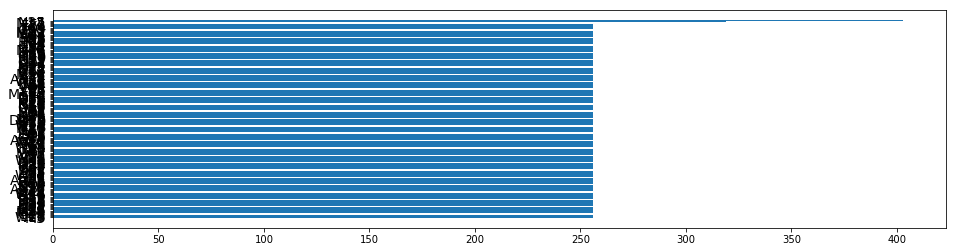

In [124]:
plt.figure(figsize = (16, 4))
n_rows = tr_counts.shape[0]
# n_to_display = 40
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, tr_counts["ct"])
plt.yticks(xaxis, tr_counts["label"], fontsize = 14)
# plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

# test

### first check my data distribution

In [162]:
ts_rootpath = os.path.join(rootpath, "test")
files = [x for x in os.listdir(ts_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
ts_fnames = pd.DataFrame(columns = ["fname"])
for fpath in files:
    pngfile = os.path.join(ts_rootpath, fpath)
    ts_fnames = pd.concat([ts_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
ts_fnames.reset_index(drop = True, inplace = True)

In [163]:
ts_fnames.tail(1)['fname'].tolist()[0]

'../EgyptianHieroglyphDataset/MyTrainTest/test/070226_N35.png'

In [164]:
ts_fnames['label'] = ts_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [165]:
ts_fnames.tail(1)

,fname,label
511,../EgyptianHieroglyphDataset/MyTrainTest/test/...,N35


In [166]:
ts_counts = pd.DataFrame(ts_fnames["label"].value_counts())
ts_counts.reset_index(inplace = True)
ts_counts.columns = ["label", "ct"]
ts_counts.sort_values(by = "ct", inplace = True, ascending = False)
ts_counts.reset_index(drop = True, inplace = True)
ts_counts.head(2)

,label,ct
0,M17,46
1,N35,46


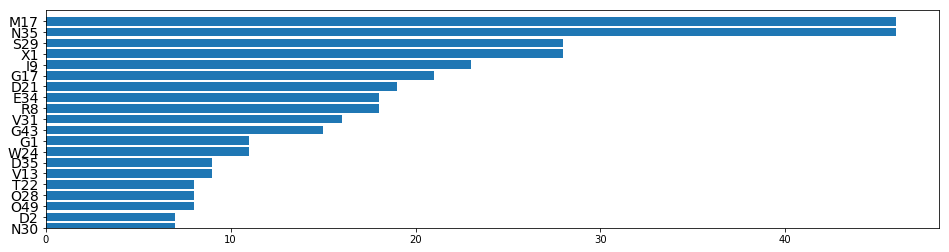

In [167]:
plt.figure(figsize = (16, 4))
n_rows = ts_counts.shape[0]
n_to_display = 20
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, ts_counts["ct"])
plt.yticks(xaxis, ts_counts["label"], fontsize = 14)
plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

### calculate how many new images to generate while keeping distribution roughly as is
Note: testing data distribution seems to follow freq distribution in real life (i.e. text from pyramid of Unas)

In [131]:
cap

256

In [133]:
ts_counts["ct"].sum()

445

In [141]:
cap - (ts_counts["ct"].sum() - cap)

67

In [143]:
ts_counts["ct"].shape

(67,)

In [149]:
ts_fnames.tail(1)

,fname,label
444,../EgyptianHieroglyphDataset/MyTrainTest/test/...,N35


### need to generate exactly 67 new images

In [159]:
test_cat_li = list(ts_counts['label'])

In [160]:
start = datetime.now()
shape_dim = (1, 1) + (original_dim)
counter = 0
harcode_gennumber = 0
for label in test_cat_li:
    pngfile = random.choice(list(ts_fnames.loc[ts_fnames['label'] == label, 'fname']))
    print(counter, label, pngfile)
    arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
    arrayfile = np.reshape(arrayfile, shape_dim) # note: no rescaling here!
    genflow = datagen.flow(x = arrayfile, y = None, batch_size=1, save_to_dir=None)
    for new_arrayfile in genflow:
        new_arrayfile = np.reshape(new_arrayfile, original_dim)
        fname = "gen" + str(harcode_gennumber) + "_" + pngfile.split("/")[-1]
        fpath = os.path.join(rootpath, "test", fname)
        # print(fpath)
        imsave(fpath, new_arrayfile)
        break
    counter += 1
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

0 M17 ../EgyptianHieroglyphDataset/MyTrainTest/test/070345_M17.png
1 N35 ../EgyptianHieroglyphDataset/MyTrainTest/test/070053_N35.png
2 X1 ../EgyptianHieroglyphDataset/MyTrainTest/test/070013_X1.png
3 S29 ../EgyptianHieroglyphDataset/MyTrainTest/test/070376_S29.png
4 I9 ../EgyptianHieroglyphDataset/MyTrainTest/test/070160_I9.png
5 G17 ../EgyptianHieroglyphDataset/MyTrainTest/test/070305_G17.png
6 D21 ../EgyptianHieroglyphDataset/MyTrainTest/test/070411_D21.png
7 R8 ../EgyptianHieroglyphDataset/MyTrainTest/test/070176_R8.png
8 E34 ../EgyptianHieroglyphDataset/MyTrainTest/test/070087_E34.png
9 V31 ../EgyptianHieroglyphDataset/MyTrainTest/test/070120_V31.png
10 G43 ../EgyptianHieroglyphDataset/MyTrainTest/test/070044_G43.png
11 W24 ../EgyptianHieroglyphDataset/MyTrainTest/test/070265_W24.png
12 G1 ../EgyptianHieroglyphDataset/MyTrainTest/test/070008_G1.png
13 D35 ../EgyptianHieroglyphDataset/MyTrainTest/test/070268_D35.png
14 V13 ../EgyptianHieroglyphDataset/MyTrainTest/test/070060_V13.pn

L1 0 63 ../EgyptianHieroglyphDataset/MyTrainTest/test/gen0_070065_L1.png


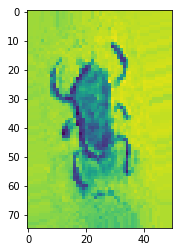

In [161]:
# spot check
print(label, row, i, fpath)
plt.figure()
plt.imshow(np.reshape(new_arrayfile, original_dim))
plt.show()